# 📈 Long Term Analysis

**Objectif**: Analyser les tendances à long terme des ratings et détecter les évolutions comportementales.

## 🔍 Questions exploratoires:
- Les utilisateurs deviennent-ils plus/moins sévères dans le temps ?
- Quand la plateforme a-t-elle connu ses pics/creux d'activité ?
- Les power users changent-ils leurs habitudes ?
- Y a-t-il eu des événements perturbateurs ?
- La croissance rapide nuit-elle à la qualité ?

In [1]:
# Import minimal nécessaire pour l'analyse long-term
import sys
sys.path.append('..')

# fonctions de chargement de data (internes)
from _data_utils.data_utils_ratings import load_ratings_for_longterm_analysis

# librairies de base
import pandas as pd
import numpy as np

# visualisation minimale utilisée ici (matplotlib suffit)
import matplotlib.pyplot as plt

# statistiques (utilisées pour tests et régression)
from scipy import stats
from scipy.stats import kendalltau, linregress, spearmanr

# Suppression des warnings inutiles
import warnings
warnings.filterwarnings('ignore')

print("✅ Imports minimaux terminés")

# Chargement optimisé des statistiques mensuelles (fonction spécialisée)
print("🔄 Chargement des données avec filtrage robuste optimisé...")
monthly_stats, metadata = load_ratings_for_longterm_analysis(
    min_interactions=100, 
    return_metadata=True, 
    verbose=False
)

print(f"✅ Données long-term chargées: {len(monthly_stats)} mois")
print(f"📊 Mois exclus: {metadata['mois_exclus']} ({metadata['pct_exclus']:.1f}%)")
print(f"📅 Période: {metadata['periode_apres']}")
print(f"📈 Volume moyen: {metadata['volume_moyen_apres']:.0f} interactions/mois")

# Métadonnées disponibles pour analyses ultérieures
print(f"\n💡 Métadonnées disponibles: {list(metadata.keys())}")


✅ _data_utils module chargé (common + ratings + recipes)
✅ Imports minimaux terminés
🔄 Chargement des données avec filtrage robuste optimisé...
✅ Imports minimaux terminés
🔄 Chargement des données avec filtrage robuste optimisé...
✅ Données long-term chargées: 211 mois
📊 Mois exclus: 15 (6.6%)
📅 Période: 2001-06 → 2018-12
📈 Volume moyen: 5076 interactions/mois

💡 Métadonnées disponibles: ['seuil_applique', 'mois_total', 'mois_exclus', 'mois_conserves', 'pct_exclus', 'periode_avant', 'periode_apres', 'gaps_temporels', 'volume_moyen_avant', 'volume_moyen_apres']
✅ Données long-term chargées: 211 mois
📊 Mois exclus: 15 (6.6%)
📅 Période: 2001-06 → 2018-12
📈 Volume moyen: 5076 interactions/mois

💡 Métadonnées disponibles: ['seuil_applique', 'mois_total', 'mois_exclus', 'mois_conserves', 'pct_exclus', 'periode_avant', 'periode_apres', 'gaps_temporels', 'volume_moyen_avant', 'volume_moyen_apres']


📈 ANALYSE TENDANCE LONG TERME
🔍 Test de Mann-Kendall:
Statistique S: -6889
Z-score: -6.7184
P-value: 0.0000
🎯 Résultat: TENDANCE SIGNIFICATIVE - Direction: BAISSE

📊 Régression linéaire:
Pente: -0.000594 points/mois
R²: 0.1620
Évolution annuelle: -0.0071 points/an


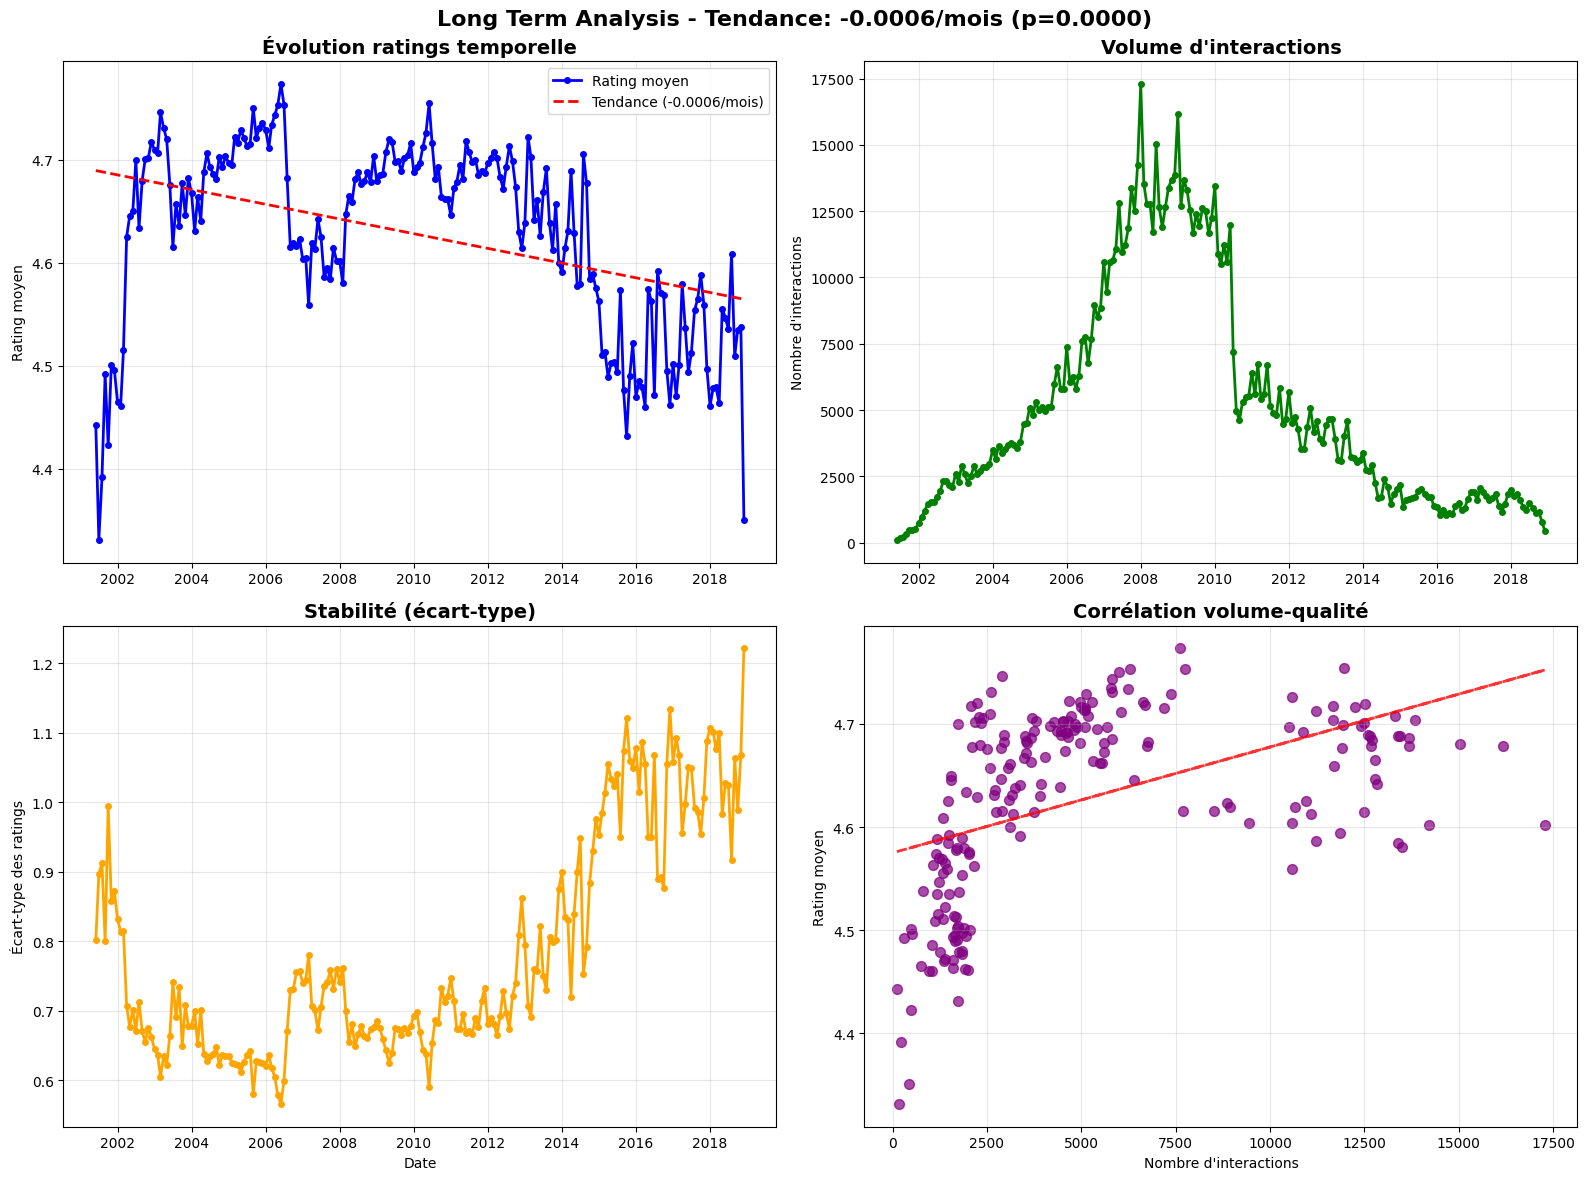


💡 Insights Long Term:
• Direction: Dégradation continue
• Force: 0.0071 points par an
• Fiabilité: R² = 0.162
• Volume-Qualité: ρ = 0.626 (p = 0.0000)
  ✅ Plus d'activité = Meilleure qualité


In [2]:
# 🔍 ANALYSE 1: TENDANCE LONG TERME DES RATINGS
print("=" * 60)
print("📈 ANALYSE TENDANCE LONG TERME")
print("=" * 60)

# Test de Mann-Kendall pour détecter tendance monotone
def mann_kendall_test(data):
    """Implémentation du test de Mann-Kendall pour détecter les tendances"""
    n = len(data)
    s = 0
    
    for i in range(n-1):
        for j in range(i+1, n):
            if data[j] > data[i]:
                s += 1
            elif data[j] < data[i]:
                s -= 1
    
    # Variance
    var_s = n * (n-1) * (2*n+5) / 18
    
    # Statistique de test
    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:
        z = 0
    
    # P-value (bilatéral)
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    return z, p_value, s

# Application du test
z_mk, p_mk, s_mk = mann_kendall_test(monthly_stats['mean_rating'].values)

print(f"🔍 Test de Mann-Kendall:")
print(f"Statistique S: {s_mk}")
print(f"Z-score: {z_mk:.4f}")
print(f"P-value: {p_mk:.4f}")

interpretation = "TENDANCE SIGNIFICATIVE" if p_mk < 0.05 else "PAS DE TENDANCE CLAIRE"
direction = "HAUSSE" if s_mk > 0 else "BAISSE" if s_mk < 0 else "STABLE"
print(f"🎯 Résultat: {interpretation} - Direction: {direction}")

# Régression linéaire pour quantifier (implémentation native)
X = np.arange(len(monthly_stats))
y = monthly_stats['mean_rating'].values

# Calcul de la régression linéaire avec scipy
trend_slope, intercept, r_value, p_value_reg, std_err = linregress(X, y)
trend_r2 = r_value ** 2

print(f"\n📊 Régression linéaire:")
print(f"Pente: {trend_slope:.6f} points/mois")
print(f"R²: {trend_r2:.4f}")
print(f"Évolution annuelle: {trend_slope * 12:.4f} points/an")

# Visualisation tendance avec Matplotlib (plus stable)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Tendance rating
ax1.plot(monthly_stats['date'], monthly_stats['mean_rating'], 'bo-', linewidth=2, markersize=4, label='Rating moyen')
# Ligne de tendance
trend_line = intercept + trend_slope * X
ax1.plot(monthly_stats['date'], trend_line, 'r--', linewidth=2, label=f'Tendance ({trend_slope:.4f}/mois)')
ax1.set_title("Évolution ratings temporelle", fontsize=14, fontweight='bold')
ax1.set_ylabel("Rating moyen")
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. Volume d'interactions
ax2.plot(monthly_stats['date'], monthly_stats['n_interactions'], 'go-', linewidth=2, markersize=4)
ax2.set_title("Volume d'interactions", fontsize=14, fontweight='bold')
ax2.set_ylabel("Nombre d'interactions")
ax2.grid(True, alpha=0.3)

# 3. Stabilité (écart-type)
ax3.plot(monthly_stats['date'], monthly_stats['std_rating'], 'o-', color='orange', linewidth=2, markersize=4)
ax3.set_title("Stabilité (écart-type)", fontsize=14, fontweight='bold')
ax3.set_ylabel("Écart-type des ratings")
ax3.set_xlabel("Date")
ax3.grid(True, alpha=0.3)

# 4. Scatter volume vs qualité
ax4.scatter(monthly_stats['n_interactions'], monthly_stats['mean_rating'], 
           color='purple', alpha=0.7, s=50)
ax4.set_title("Corrélation volume-qualité", fontsize=14, fontweight='bold')
ax4.set_xlabel("Nombre d'interactions")
ax4.set_ylabel("Rating moyen")
ax4.grid(True, alpha=0.3)

# Ajout de la ligne de corrélation
z = np.polyfit(monthly_stats['n_interactions'], monthly_stats['mean_rating'], 1)
p = np.poly1d(z)
ax4.plot(monthly_stats['n_interactions'], p(monthly_stats['n_interactions']), 
         "r--", alpha=0.8, linewidth=2)

plt.suptitle(f"Long Term Analysis - Tendance: {trend_slope:+.4f}/mois (p={p_mk:.4f})", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n💡 Insights Long Term:")
print(f"• Direction: {'Amélioration' if trend_slope > 0 else 'Dégradation'} continue")
print(f"• Force: {abs(trend_slope * 12):.4f} points par an")
print(f"• Fiabilité: R² = {trend_r2:.3f}")

# Corrélation volume vs qualité
corr_vol_qual, p_corr = spearmanr(monthly_stats['n_interactions'], monthly_stats['mean_rating'])
print(f"• Volume-Qualité: ρ = {corr_vol_qual:.3f} (p = {p_corr:.4f})")

if p_corr < 0.05:
    if corr_vol_qual > 0:
        print("  ✅ Plus d'activité = Meilleure qualité")
    else:
        print("  ⚠️ Plus d'activité = Qualité dégradée")
else:
    print("  ℹ️ Pas de lien significatif volume-qualité")

## 📊 Informations sur les données chargées

Les statistiques mensuelles ont été chargées et filtrées automatiquement par `load_ratings_for_longterm_analysis()` :
- ✅ Filtrage robuste appliqué (seuil: 100 interactions/mois minimum)
- ✅ Métadonnées disponibles pour analyses complémentaires
- ✅ Continuité temporelle préservée

In [7]:
# 📊 Affichage des métadonnées de filtrage robuste
print("=" * 60)
print("📊 RÉSULTATS DU FILTRAGE ROBUSTE")
print("=" * 60)

print(f"\n🎯 Configuration:")
print(f"   Seuil appliqué: {metadata['seuil_applique']} interactions/mois")

print(f"\n📈 Impact du filtrage:")
print(f"   Mois avant filtrage: {metadata['mois_total']}")
print(f"   Mois après filtrage: {metadata['mois_conserves']}")
print(f"   Mois exclus: {metadata['mois_exclus']} ({metadata['pct_exclus']:.1f}%)")

print(f"\n📅 Période d'analyse:")
print(f"   Avant: {metadata['periode_avant']}")
print(f"   Après: {metadata['periode_apres']}")

print(f"\n📊 Qualité des données:")
print(f"   Volume moyen avant: {metadata['volume_moyen_avant']:.0f} interactions/mois")
print(f"   Volume moyen après: {metadata['volume_moyen_apres']:.0f} interactions/mois")
print(f"   Gaps temporels: {'⚠️ Oui' if metadata['gaps_temporels'] else '✅ Non'}")

print(f"\n✅ Dataset validé pour analyses statistiques robustes!")
print(f"   → {len(monthly_stats)} points de données disponibles")
print(f"   → Volume minimum garanti: {monthly_stats['n_interactions'].min()} interactions")


📊 RÉSULTATS DU FILTRAGE ROBUSTE

🎯 Configuration:
   Seuil appliqué: 100 interactions/mois

📈 Impact du filtrage:
   Mois avant filtrage: 226
   Mois après filtrage: 211
   Mois exclus: 15 (6.6%)

📅 Période d'analyse:
   Avant: 2000-01 → 2018-12
   Après: 2001-06 → 2018-12

📊 Qualité des données:
   Volume moyen avant: 4741 interactions/mois
   Volume moyen après: 5076 interactions/mois
   Gaps temporels: ✅ Non

✅ Dataset validé pour analyses statistiques robustes!
   → 211 points de données disponibles
   → Volume minimum garanti: 113 interactions


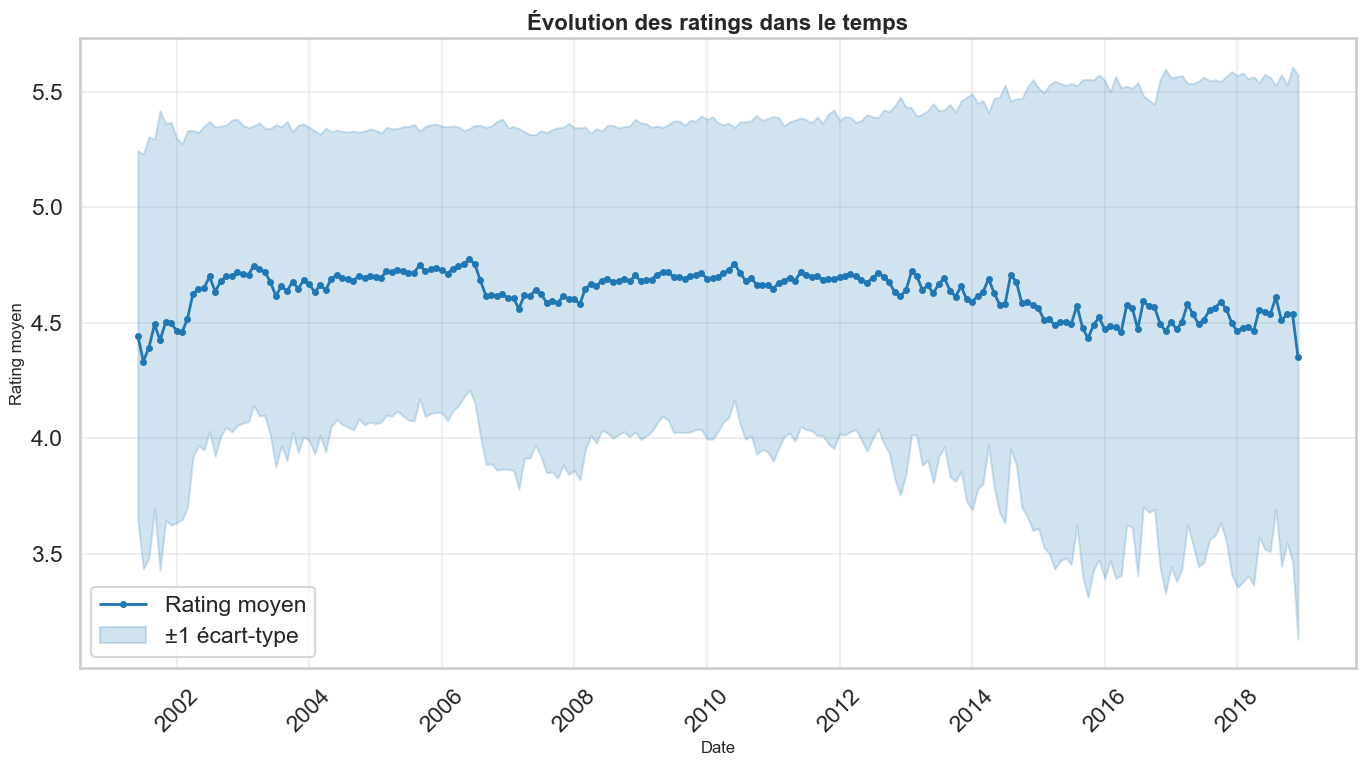

In [8]:
# Graphique évolution long terme avec Matplotlib
fig, ax = plt.subplots(figsize=(14, 8))

# Ligne principale : moyenne mobile
ax.plot(monthly_pd['date'], monthly_pd['mean_rating'], 'o-', 
        color='#1f77b4', linewidth=2, markersize=4, label='Rating moyen')

# Bandes de confiance (±1 std)
ax.fill_between(monthly_pd['date'], 
                monthly_pd['mean_rating'] - monthly_pd['std_rating'],
                monthly_pd['mean_rating'] + monthly_pd['std_rating'],
                alpha=0.2, color='#1f77b4', label='±1 écart-type')

ax.set_title('Évolution des ratings dans le temps', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Rating moyen', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend()

# Rotation des dates pour meilleure lisibilité
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 📊 Analyse de volume vs qualité

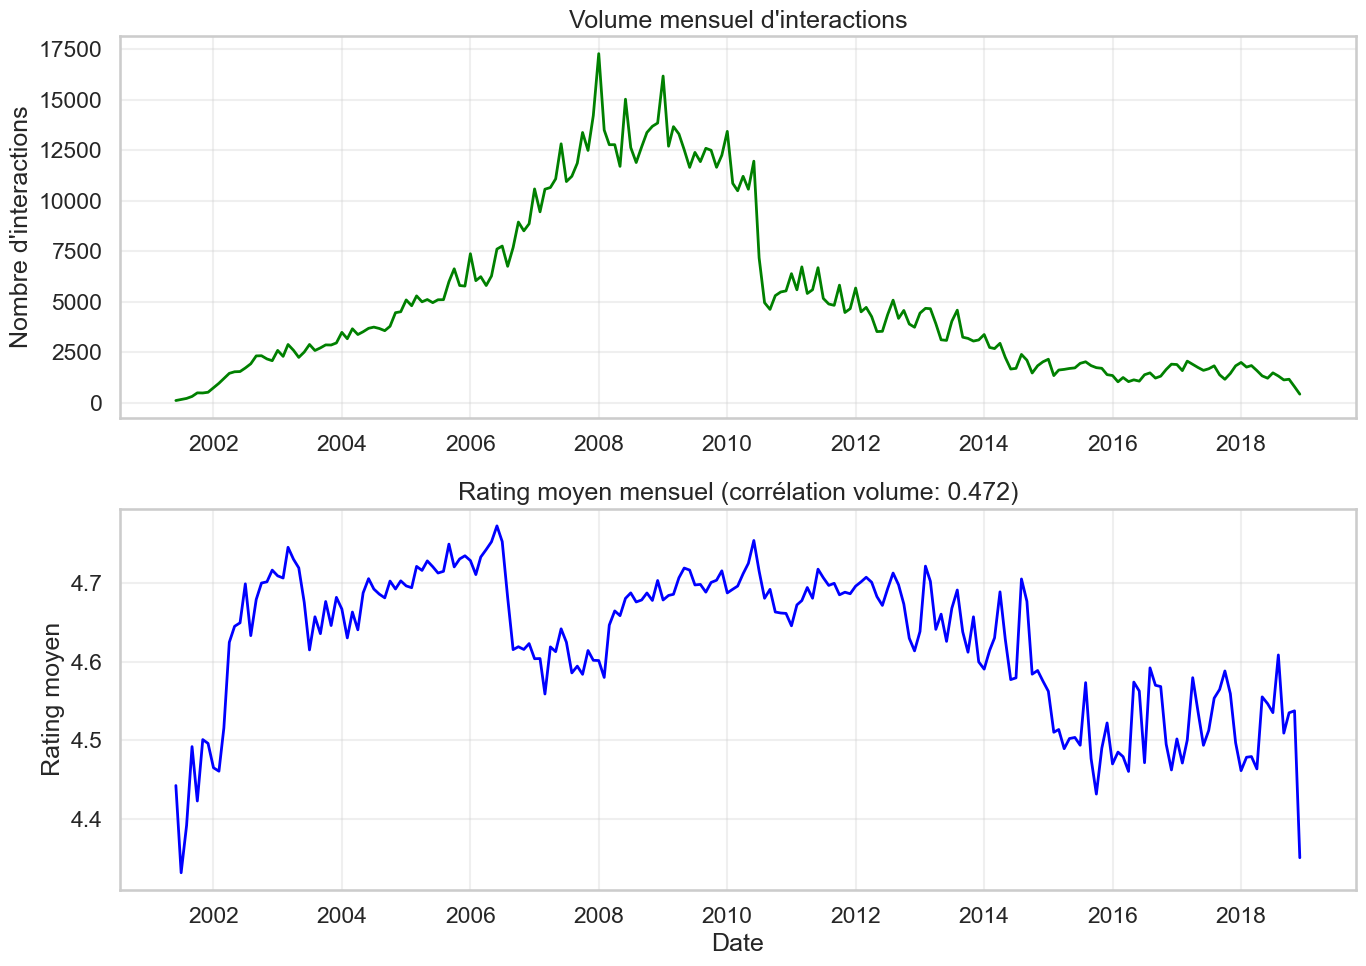

📈 Corrélation volume/rating: 0.472
⚠️  Corrélation notable - à investiguer


In [9]:
# Corrélation volume/rating par mois
correlation = monthly_pd[['n_interactions', 'mean_rating']].corr().iloc[0, 1]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Volume mensuel
ax1.plot(monthly_pd['date'], monthly_pd['n_interactions'], color='green', linewidth=2)
ax1.set_title('Volume mensuel d\'interactions')
ax1.set_ylabel('Nombre d\'interactions')
ax1.grid(True, alpha=0.3)

# Rating mensuel
ax2.plot(monthly_pd['date'], monthly_pd['mean_rating'], color='blue', linewidth=2)
ax2.set_title(f'Rating moyen mensuel (corrélation volume: {correlation:.3f})')
ax2.set_ylabel('Rating moyen')
ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📈 Corrélation volume/rating: {correlation:.3f}")
if abs(correlation) > 0.3:
    print("⚠️  Corrélation notable - à investiguer")
else:
    print("✅ Faible corrélation volume/qualité")

## 📈 Tests statistiques de tendance

In [10]:
# Test de Mann-Kendall pour détecter une tendance temporelle
from scipy.stats import kendalltau

# Préparation des données pour le test
monthly_sorted = monthly_pd.sort_values('date')
time_index = range(len(monthly_sorted))
ratings = monthly_sorted['mean_rating'].values

# Test de corrélation de Kendall (approximation du Mann-Kendall)
tau, p_value = kendalltau(time_index, ratings)

print(f"📊 Test de tendance temporelle:")
print(f"   Tau de Kendall: {tau:.4f}")
print(f"   p-value: {p_value:.4f}")

if p_value < 0.05:
    direction = "croissante" if tau > 0 else "décroissante"
    print(f"   ✅ Tendance {direction} significative")
else:
    print(f"   ❌ Pas de tendance significative")

# Régression linéaire pour quantifier la pente
from scipy.stats import linregress
slope, intercept, r_value, p_value_reg, std_err = linregress(time_index, ratings)

print(f"\n📈 Régression linéaire:")
print(f"   Pente: {slope:.6f} points/mois")
print(f"   R²: {r_value**2:.4f}")
print(f"   p-value: {p_value_reg:.4f}")

# Pente annualisée
annual_slope = slope * 12
print(f"   📅 Évolution annuelle: {annual_slope:.4f} points/an")

📊 Test de tendance temporelle:
   Tau de Kendall: -0.3109
   p-value: 0.0000
   ✅ Tendance décroissante significative

📈 Régression linéaire:
   Pente: -0.000594 points/mois
   R²: 0.1620
   p-value: 0.0000
   📅 Évolution annuelle: -0.0071 points/an
